Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/Skin_cancer_Images.zip', 'r') as zip_ref:
  zip_ref.extractall()

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [3]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/Skin_cancer_Images/Train")
data_dir_test = pathlib.Path('/content/Skin_cancer_Images/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset = 'training',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset = 'validation',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### create a code to visualize one instance of all the nine classes present in the dataset

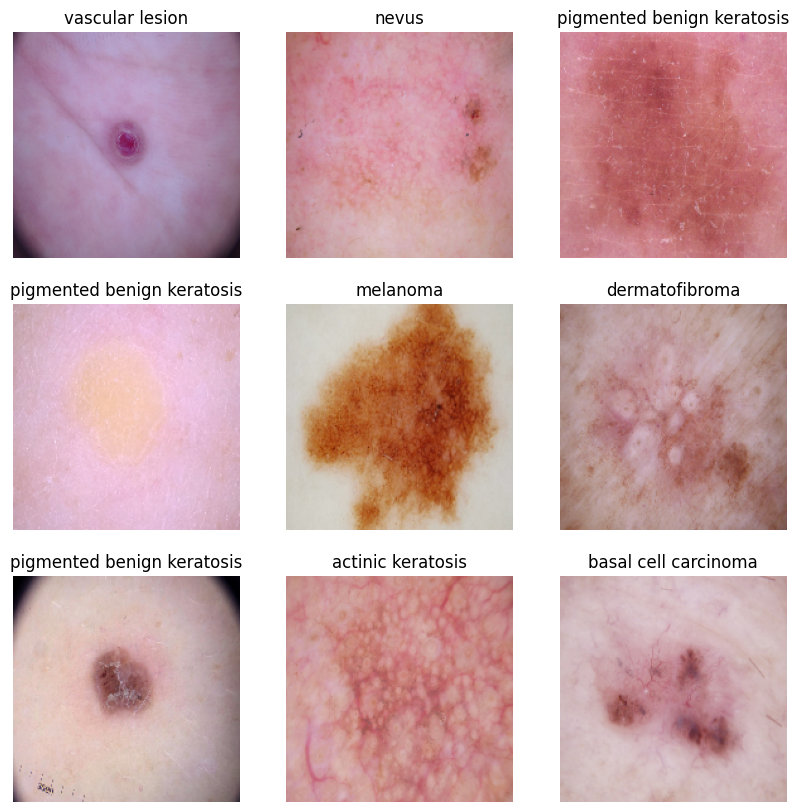

In [19]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### **Create the model-1**
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
### Your code goes here
# Number of target labels are 9
target_labels = 9

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [31]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
# View the summary of all layers
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [27]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.1963 - loss: 2.1528 - val_accuracy: 0.3177 - val_loss: 1.9177
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.2981 - loss: 1.9145 - val_accuracy: 0.3333 - val_loss: 1.8040
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.3414 - loss: 1.8201 - val_accuracy: 0.3758 - val_loss: 1.7453
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.3834 - loss: 1.7042 - val_accuracy: 0.4877 - val_loss: 1.5343
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.4629 - loss: 1.5565 - val_accuracy: 0.4877 - val_loss: 1.5013
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.4793 - loss: 1.4819 - val_accuracy: 0.5280 - val_loss: 1.4263
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.5107 - loss: 1.3883 - val_accuracy: 0.5391 - val_loss: 1.4201
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.5630 - loss: 1.2876 - val_accuracy: 0.5369 - val_loss:

### Visualizing training results

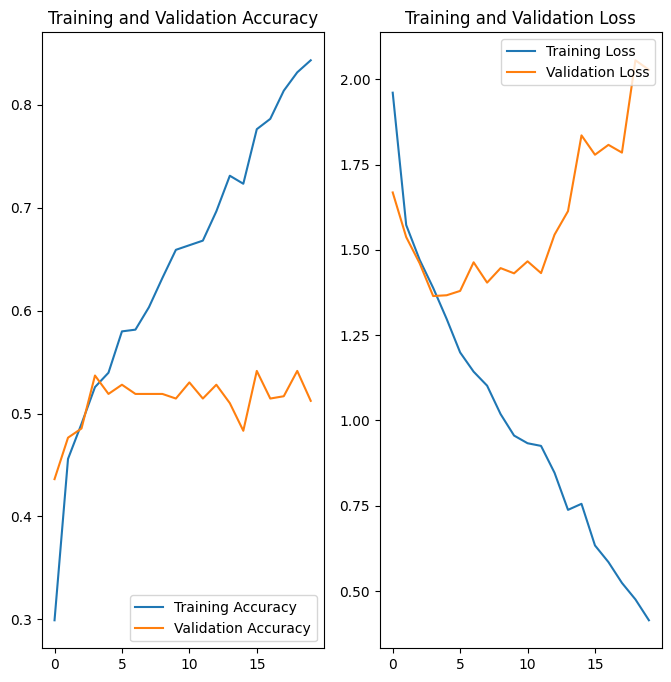

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Observations:

1. The model’s training accuracy gradually climbs to about 90%, yet the validation accuracy remains stagnant at approximately 55%.

2. A high training accuracy indicates that the model has learned even the noise in the data. However, its poor performance on validation data reveals it lacks generalization.

3. These patterns clearly demonstrate overfitting. To counter this, augmentation techniques will be applied. Given the limited available training data, new samples will be created by slightly altering existing data (e.g., flipping images horizontally/vertically, minor rotations), and these will be used for further training.

In [33]:
# after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy using Keras library.

augmentation_data = keras.Sequential([
                                      layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
                                      layers.RandomRotation(0.1),
                                      layers.RandomZoom(0.1),
])

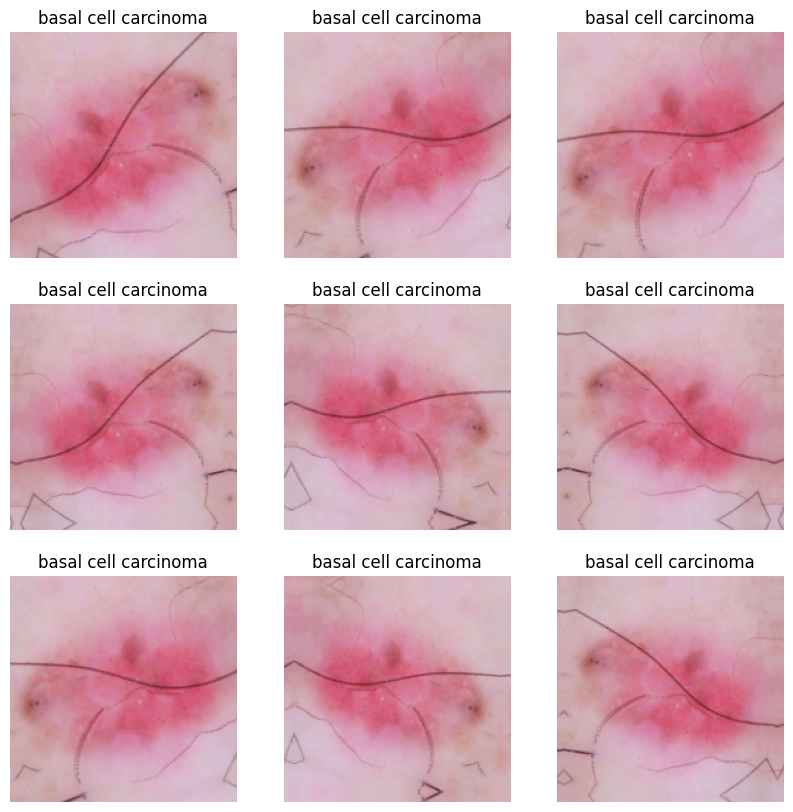

In [20]:
# visualize how your augmentation strategy works for one instance of training image.

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_images = augmentation_data(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[labels[0]])
        plt.axis("off")


### **Create the model-2**


In [34]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential([
  augmentation_data,
  layers.Rescaling(1./255),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])



### Compiling the model

In [35]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [36]:
# View the summary of all layers
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [37]:
%%time
epochs = 20
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.2252 - loss: 2.4529 - val_accuracy: 0.3445 - val_loss: 1.7698
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.3754 - loss: 1.7372 - val_accuracy: 0.4497 - val_loss: 1.6555
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.4451 - loss: 1.5870 - val_accuracy: 0.4586 - val_loss: 1.5020
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.4637 - loss: 1.5092 - val_accuracy: 0.4877 - val_loss: 1.4617
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.4780 - loss: 1.4582 - val_accuracy: 0.5347 - val_loss: 1.4062
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.5152 - loss: 1.4081 - val_accuracy: 0.4944 - val_loss: 1.4462
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.4719 - loss: 1.4701 - val_accuracy: 0.5078 - val_loss: 1.4412
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.5344 - loss: 1.3169 - val_accuracy: 0.5324 - val_loss

### Visualizing the results

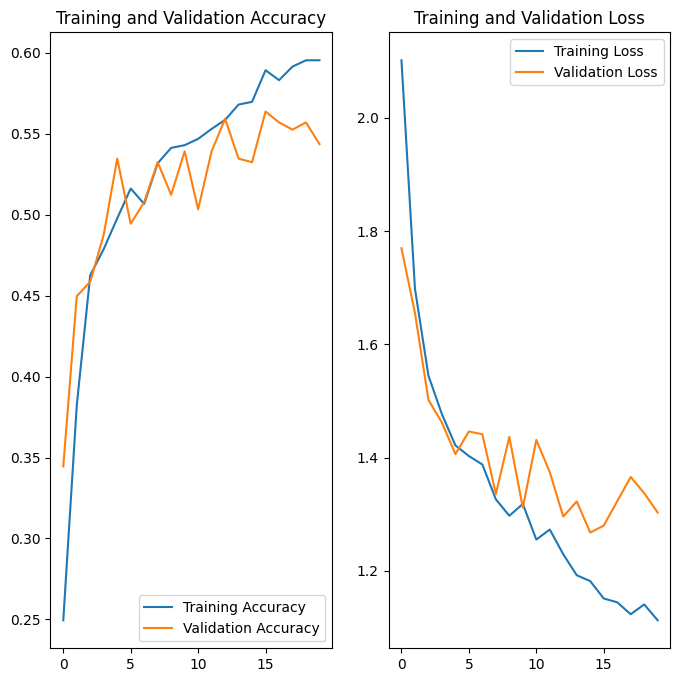

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **Observations:**

1. By leveraging augmented data, overfitting has been effectively addressed.

2. The training and validation accuracy of the aforementioned model fall within a similar range.

3. Both the training and validation data are showing poor performance, indicating that the model is now exhibiting underfitting.

#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [39]:
## Your code goes here.

from glob import glob

## find the image path for all class labels (lesions)
images_path_list = [ i for i in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]

## Extract the class labels (lesions)
lesions_list = [ os.path.basename(os.path.dirname(j)) for j in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]
print(len(lesions_list))

2239


In [40]:
# Extract image path and class label in a dictionary
image_dict = dict(zip(images_path_list, lesions_list))
print(list(image_dict.items())[:5])

[('/content/Skin_cancer_Images/Train/basal cell carcinoma/ISIC_0025467.jpg', 'basal cell carcinoma'), ('/content/Skin_cancer_Images/Train/basal cell carcinoma/ISIC_0026091.jpg', 'basal cell carcinoma'), ('/content/Skin_cancer_Images/Train/basal cell carcinoma/ISIC_0027976.jpg', 'basal cell carcinoma'), ('/content/Skin_cancer_Images/Train/basal cell carcinoma/ISIC_0028095.jpg', 'basal cell carcinoma'), ('/content/Skin_cancer_Images/Train/basal cell carcinoma/ISIC_0030335.jpg', 'basal cell carcinoma')]


In [41]:
# View the image path and class label in a df
lesions_df = pd.DataFrame(list(image_dict.items()), columns=['Image Path', 'Label'])
lesions_df.head()

Image Path                 Label
0  /content/Skin_cancer_Images/Train/basal cell c...  basal cell carcinoma
1  /content/Skin_cancer_Images/Train/basal cell c...  basal cell carcinoma
2  /content/Skin_cancer_Images/Train/basal cell c...  basal cell carcinoma
3  /content/Skin_cancer_Images/Train/basal cell c...  basal cell carcinoma
4  /content/Skin_cancer_Images/Train/basal cell c...  basal cell carcinoma

In [42]:
# inspecting the distribution of classes in the data
lesions_df[['Label']].value_counts()

Label                     
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: count, dtype: int64

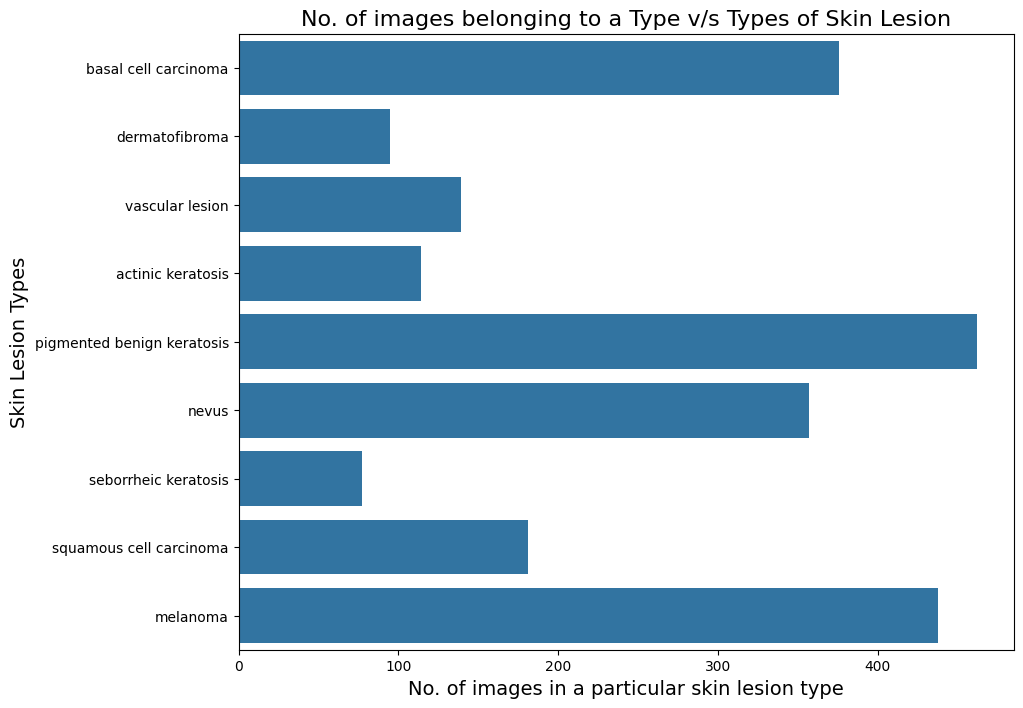

In [43]:
# Visualize the distribution of classes using a countplot

import seaborn as sns

plt.figure(figsize=(10, 8))
sns.countplot(y="Label", data=lesions_df)
plt.title('No. of images belonging to a Type v/s Types of Skin Lesion', fontsize=16)
plt.xlabel('No. of images in a particular skin lesion type', fontsize=14)
plt.ylabel('Skin Lesion Types', fontsize=14)
plt.show()

In [44]:
round(lesions_df[['Label']].value_counts(normalize=True)*100, 2)

Label                     
pigmented benign keratosis    20.63
melanoma                      19.56
basal cell carcinoma          16.79
nevus                         15.94
squamous cell carcinoma        8.08
vascular lesion                6.21
actinic keratosis              5.09
dermatofibroma                 4.24
seborrheic keratosis           3.44
Name: proportion, dtype: float64

### **Observations:**

1. A clear class imbalance is evident within the training data.

2. The class "seborrheic keratosis" comprises the smallest proportion of samples, accounting for approximately 3.44%.

3. "Pigmented benign keratosis" and "melanoma" significantly outweigh other classes, representing approximately 20.63% and 19.56% of the data, respectively.


#### Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [45]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [47]:
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [48]:
path_to_training_dataset= str(data_dir_train) + '/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/Skin_cancer_Images/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7826D7BA8610>: 100%|██████████| 500/500 [00:23<00:00, 21.14 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin_cancer_Images/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7826DFCB18A0>: 100%|██████████| 500/500 [00:18<00:00, 26.85 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin_cancer_Images/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7826F0488130>: 100%|██████████| 500/500 [00:19<00:00, 25.85 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin_cancer_Images/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7826DFD70C10>: 100%|██████████| 500/500 [01:54<00:00,  4.35 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin_cancer_Images/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=919x802 at 0x7826F0305420>: 100%|██████████| 500/500 [01:39<00:00,  5.03 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin_cancer_Images/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78277B32B670>: 100%|██████████| 500/500 [00:22<00:00, 22.54 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin_cancer_Images/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7826DFFA12A0>: 100%|██████████| 500/500 [00:45<00:00, 11.09 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin_cancer_Images/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7826F03666B0>: 100%|██████████| 500/500 [00:19<00:00, 25.12 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin_cancer_Images/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7826F428CDC0>: 100%|██████████| 500/500 [00:21<00:00, 22.85 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [49]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [50]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:5]

['basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma']

In [54]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Image Path','Label'])
new_df = pd.concat([lesions_df, df2], ignore_index=True)
new_df.shape

In [ ]:
new_df['Label'].value_counts()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [53]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new[:5]

['/content/Skin_cancer_Images/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030349.jpg_bb03eefd-3b28-4942-97ab-f5182139d936.jpg',
 '/content/Skin_cancer_Images/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025576.jpg_fbb90516-7407-4a98-9b86-f251ba8e70ee.jpg',
 '/content/Skin_cancer_Images/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026343.jpg_6368d4da-a68b-45be-b6f2-8be4b1bb3cc1.jpg',
 '/content/Skin_cancer_Images/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029951.jpg_541f87f6-68e4-4573-9a0b-d608ce631430.jpg',
 '/content/Skin_cancer_Images/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024632.jpg_e116e278-df0a-4c98-8f13-210ea6fdbd20.jpg']

####  Train the model on the data created using Augmentor

In [55]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [56]:
# data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [57]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


###  **Create your model-3** (make sure to include normalization)

In [31]:
model = Sequential([
  augmentation_data,
  layers.Rescaling(1./255),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])

####  Compile  model (Choose optimizer and loss function appropriately)

In [32]:
## your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [33]:
# View the summary of all layers
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 180, 180, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 90, 90, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 45, 45, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,990,249 (15.22 MB)

 Trainable params: 3,990,025 (15.22 MB)

 Non-trainable params: 224 (896.00 B)

####  Train model

In [34]:
%%time
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 194ms/step - accuracy: 0.2742 - loss: 3.6048 - val_accuracy: 0.1158 - val_loss: 24.0312
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 28s 152ms/step - accuracy: 0.4328 - loss: 1.4789 - val_accuracy: 0.1863 - val_loss: 9.9741
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 151ms/step - accuracy: 0.4840 - loss: 1.3690 - val_accuracy: 0.4633 - val_loss: 1.6096
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 152ms/step - accuracy: 0.5085 - loss: 1.2576 - val_accuracy: 0.4261 - val_loss: 1.7029
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 26s 152ms/step - accuracy: 0.5355 - loss: 1.2225 - val_accuracy: 0.4944 - val_loss: 1.3831
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 153ms/step - accuracy: 0.5509 - loss: 1.1881 - val_accuracy: 0.4826 - val_loss: 1.6142
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 153ms/step - accuracy: 0.5623 - loss: 1.1318 - val_accuracy: 0.5167 - val_loss: 1.3477
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 152ms/step - accuracy: 0.5714 - loss: 

####  Visualize the model results

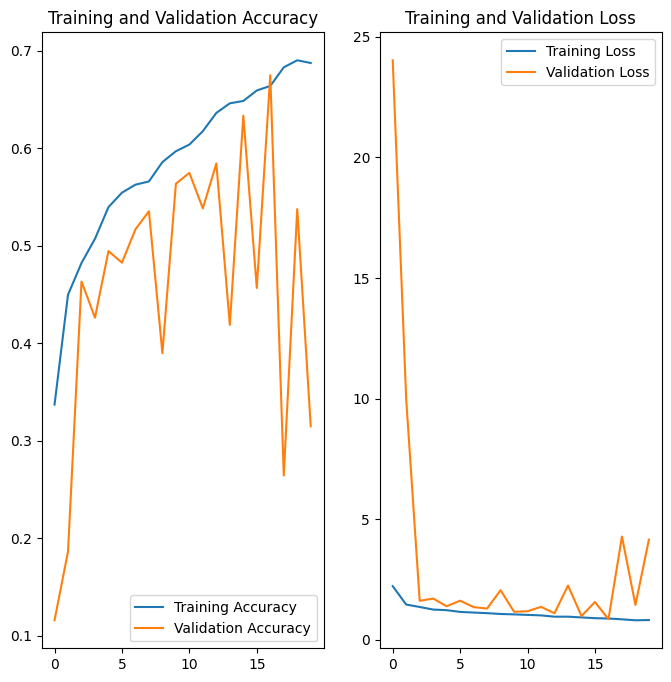

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

####   Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

Observations:

1. Implementing batch normalization in the model yielded a slight uptick in both training and validation accuracy.
2. Formulating an alternative model without batch normalization aims to investigate prospective improvements in accuracy.

### **Creating another model-4 (without batch normalization)**

In [58]:
# create the model
model = Sequential([
  augmentation_data,
  layers.Rescaling(1./255),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])

**Compiling the model**

In [59]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# ModelCheckpoint callback is employed alongside the model.fit() training process to periodically save the model
# or its weights (in a checkpoint file)
checkpoint = ModelCheckpoint("model.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)

# Early stop the training when a monitored metric ceases to show improvement
earlystop = EarlyStopping(monitor="val_accuracy", patience=5, mode="auto", verbose=1)

In [60]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_3 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

**Training the model**

In [61]:
%%time
# train the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint, earlystop]
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2770 - loss: 1.8841
Epoch 1: val_accuracy improved from -inf to 0.43356, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 259s 2s/step - accuracy: 0.2773 - loss: 1.8832 - val_accuracy: 0.4336 - val_loss: 1.5147
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4521 - loss: 1.4469
Epoch 2: val_accuracy did not improve from 0.43356
169/169 ━━━━━━━━━━━━━━━━━━━━ 257s 1s/step - accuracy: 0.4521 - loss: 1.4469 - val_accuracy: 0.4232 - val_loss: 1.4722
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4740 - loss: 1.3869
Epoch 3: val_accuracy improved from 0.43356 to 0.49517, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 261s 1s/step - accuracy: 0.4740 - loss: 1.3867 - val_accuracy: 0.4952 - val_loss: 1.3506
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5035 - loss: 1.2979
Epoch 4: val_accuracy improved from 0.49517 to 0.55902, saving model to model.keras
169/16

**Visualize the model results**

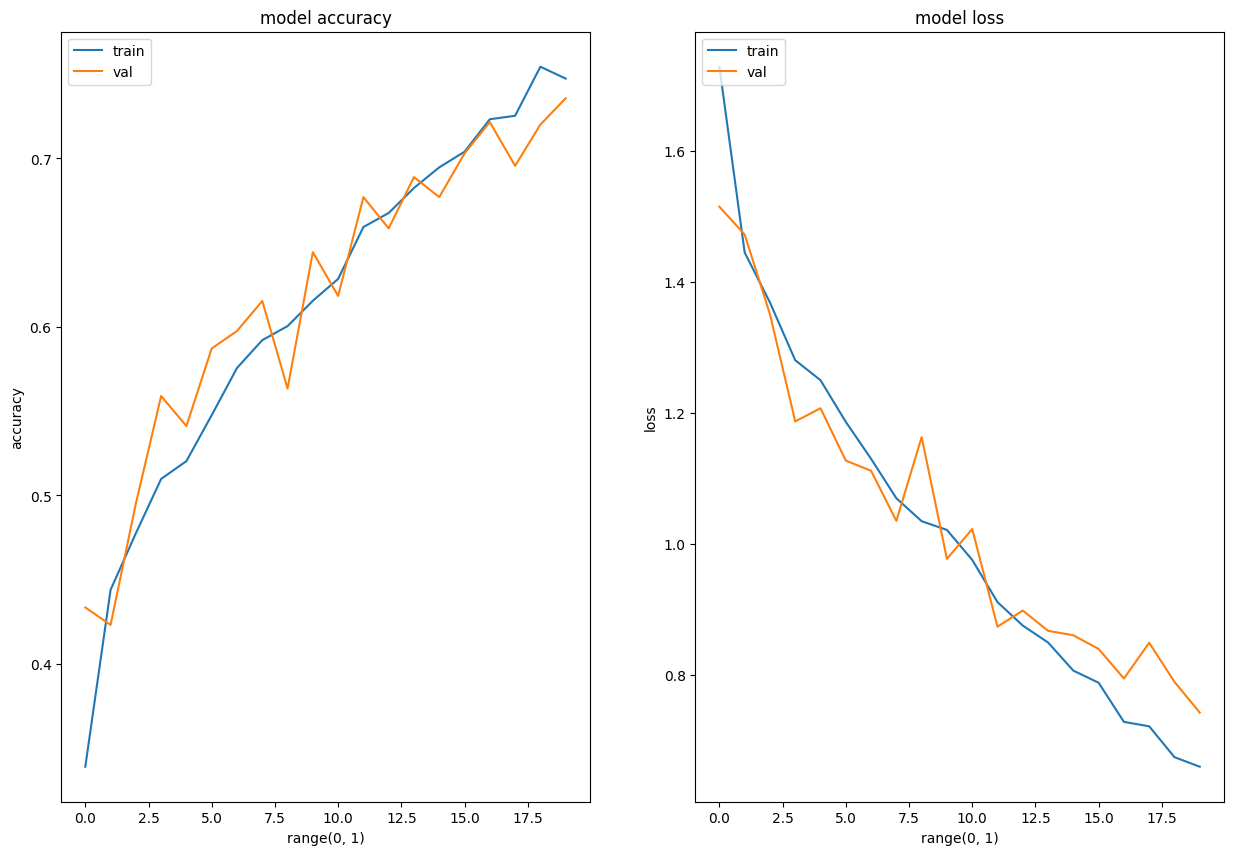

In [62]:
# Plot the training curves

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Observations:**

1. The ultimate model showcases well-balanced performance, displaying no signs of underfitting or overfitting.

2. The implementation of class rebalancing has notably enhanced the model's performance across both training and validation datasets.

3. Following 20 epochs, the final model attains an accuracy of 73% on the training set and approximately 73.5% on the validation set.

4. The narrow divergence between training and validation accuracies underscores the robust generalization capability of the final CNN model.

5. The addition of batch normalization failed to enhance both training and validation accuracy.

**Model Evaluation**

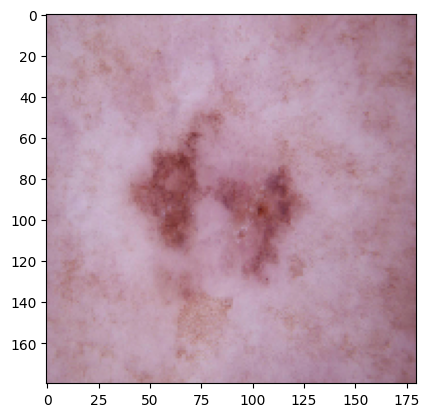

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Actual Class: actinic keratosis
Predicted Class: pigmented benign keratosis



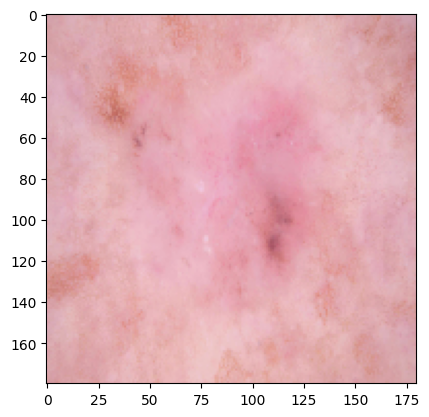

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Actual Class: basal cell carcinoma
Predicted Class: basal cell carcinoma



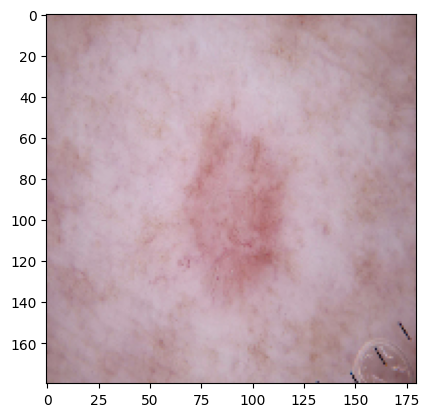

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Actual Class: dermatofibroma
Predicted Class: squamous cell carcinoma



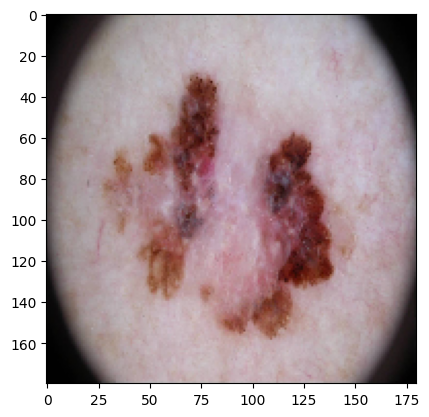

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Actual Class: melanoma
Predicted Class: melanoma



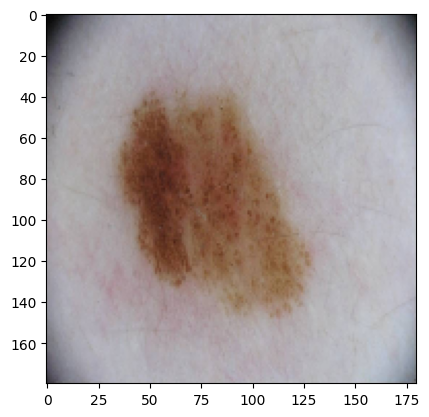

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Actual Class: nevus
Predicted Class: nevus



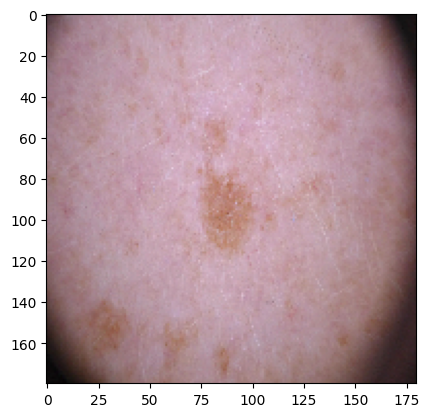

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Actual Class: pigmented benign keratosis
Predicted Class: pigmented benign keratosis



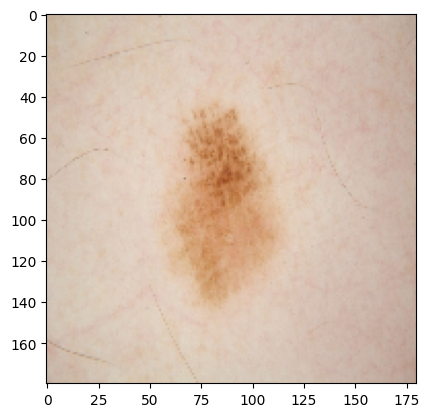

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Actual Class: seborrheic keratosis
Predicted Class: melanoma



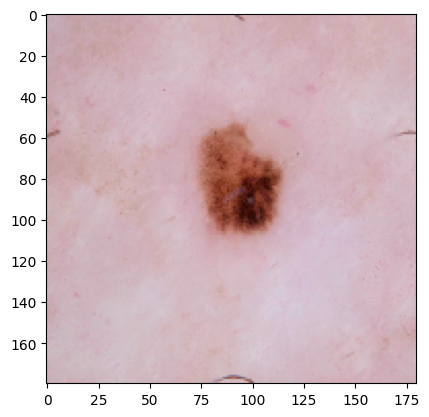

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Actual Class: squamous cell carcinoma
Predicted Class: pigmented benign keratosis



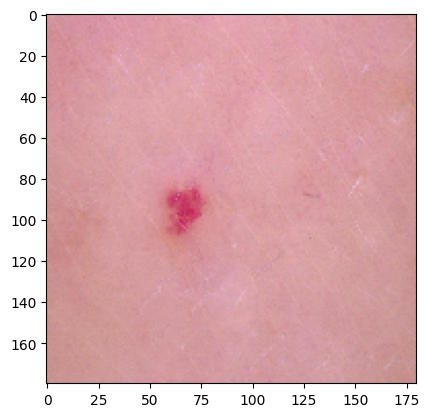

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Actual Class: vascular lesion
Predicted Class: basal cell carcinoma



In [86]:
# Evaluating our model on one of the instances in the test set

from tensorflow.keras.preprocessing.image import load_img

for i in range(len(class_names)):
  image_path_test = os.path.join(data_dir_test, class_names[i], '*')
  test_image_files = glob(image_path_test)

  if len(test_image_files) == 0:
    print(f"No images found for class {class_names[i]}")
    continue

  test_image = load_img(test_image_files[-1], target_size=(180, 180, 3))
  plt.imshow(test_image)
  plt.grid(False)
  plt.show()

  img = np.expand_dims(test_image, axis=0)
  predicted = model.predict(img)
  predicted = np.argmax(predicted)
  predicted_class = class_names[predicted]
  print(f"Actual Class: {class_names[i]}\nPredicted Class: {predicted_class}\n")

**Observations:**

1. Those classes have significant percentage of representation were predicted accurately and on the other hand those classes which have low representation were predicted incorrectly.
2. 'basal cell carcinoma' class which has 376 representation (third highest) predicted correctly.
3. 'melanoma' class which has 438 representation (second highest) predicted correctly.
4. 'nevus' class which has 357 representation (fourth highest) predicted correctly.
5. 'pigmented benign keratosis' class which has 462 representation (highest) predicted correctly.
